In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerPatch
from scipy import integrate
import sys
sys.path.append('../../scripts/')
import mpl_stylesheet
mpl_stylesheet.banskt_presentation(fontfamily = 'latex-clearsans', fontsize = 24)

In [6]:
# Data
methods = ['tejaas_rr', 'tejaas_jpa', 'matrixeqtl']
#methods = ['tejaas_jpa', 'matrixeqtl']
ntfs = [50, 100, 150]
tfscales = [5, 10, 15, 20]
srcdir = '/scratch/sbanerj/trans-eqtl/simulation'

data_ntop10pc = dict()
data_ntop05pc = dict()
data_ntop01pc = dict()

ntop10pc = 1515
ntop05pc = 757
ntop01pc = 151
fdr = 0.05

for method in methods:
    data_ntop10pc[method] = dict()
    data_ntop05pc[method] = dict()
    data_ntop01pc[method] = dict()
    for ntf in ntfs:
        data_ntop10pc[method][ntf] = dict()
        data_ntop05pc[method][ntf] = dict()
        data_ntop01pc[method][ntf] = dict()
        for tfscale in tfscales:
            simdir = "15158_450_20_800_30_{:d}_100_0.01_0.0_0.0_1.0_0.6_4.0_0.1_{:d}_0.02".format(ntf, tfscale)
            if method == 'tejaas_rr':
                rocfile = os.path.join(srcdir, simdir, 'rocdata/rr_sb0.05_tpfp.txt')
            elif method == 'tejaas_jpa':
                rocfile = os.path.join(srcdir, simdir, 'rocdata/jpa_tpfp.txt')
            elif method == 'matrixeqtl':
                rocfile = os.path.join(srcdir, simdir, 'rocdata/matrixeqtl_tpfp.txt')
    
            if os.path.exists(rocfile):
                roc = np.loadtxt(rocfile, skiprows=1)
                row_10pc = roc[np.logical_and(roc[:, 0] == fdr, roc[:, 1] == ntop10pc), :][0]
                row_05pc = roc[np.logical_and(roc[:, 0] == fdr, roc[:, 1] == ntop05pc), :][0]
                row_01pc = roc[np.logical_and(roc[:, 0] == fdr, roc[:, 1] == ntop01pc), :][0]
                data_ntop10pc[method][ntf][tfscale] = tuple([row_10pc[2], row_10pc[3]])
                data_ntop05pc[method][ntf][tfscale] = tuple([row_05pc[2], row_05pc[3]])
                data_ntop01pc[method][ntf][tfscale] = tuple([row_01pc[2], row_01pc[3]])
            else:
                data_ntop10pc[method][ntf][tfscale] = tuple([0, 0])
                data_ntop05pc[method][ntf][tfscale] = tuple([0, 0])
                data_ntop01pc[method][ntf][tfscale] = tuple([0, 0])

In [7]:
def single_barplot(ax, tp10, tp05, tp01, fp10, fp05, fp01, ymax, methodcolors, 
                   ymajorticks, yminorticks, xlabel, ylabel, showyaxis, showxlabel):
    
    yvals = tp10
    nbar = len(yvals)

    ax.set_yticks(ymajorticks)
    ax.set_yticks(yminorticks, minor=True)
    ax.tick_params(bottom = False, top = False, left = False, right = False, labelleft = False, labelbottom = False)
    ax.grid(which = 'minor', axis = 'y', linestyle = 'dotted', zorder = 0)
    
    ind = np.arange(1, nbar + 1)
    ax.bar(ind, tp01, color = methodcolors, linewidth = 0, width = 0.8, zorder = 30)
    ax.bar(ind, tp05, color = 'w', linewidth = 2, width = 0.8, edgecolor = methodcolors, hatch = '///', zorder = 20)
    ax.bar(ind, tp10, color = 'w', linewidth = 2, width = 0.8, edgecolor = methodcolors, zorder = 10)
    
    if showyaxis: 
        ax.tick_params(which = 'major', right = True, labelright = True)
        yticks = ax.get_yticks(minor = False)
        yticklabels = ['{:d}'.format(y) for y in yticks]
        ax.set_yticklabels(yticklabels, minor = False)
        ax.set_ylabel(ylabel)
        ax.yaxis.set_label_position("right")
        
    if showxlabel:
        ax.set_xlabel(xlabel)
        
    for side, border in ax.spines.items():
        if not side == 'bottom':
            border.set_visible(False)
        if showyaxis and side == 'right':
            border.set_visible(True)

    ax.set_ylim([-0.5, ymax])
    ax.set_xlim([0, nbar + 1])
    ax.set_facecolor('None')
    
class HandlerSquare(HandlerPatch):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        center = xdescent + 0.5 * (width - height), ydescent + 0.5 * (width - height)
        p = mpatches.Rectangle(xy=center, width=height,
                               height=height, angle=0.0)
        self.update_prop(p, orig_handle, legend)
        p.set_transform(trans)
        return [p]
    
class HandlerNone(HandlerPatch):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        center = xdescent + 0.5 * (width - height), ydescent + 0.5 * (width - height)
        p = mpatches.Rectangle(xy=center, width=0,
                               height=height, angle=0.0)
        self.update_prop(p, orig_handle, legend)
        p.set_transform(trans)
        return [p]
    
def method_to_yvals(methods, data):
    nrow = max([len(vals) for m, vals in data.items()])
    ncol = max([len(val2) for m, val1 in data.items() for ntf, val2 in val1.items()])
    rownames = [None for x in range(nrow)]
    colnames = [None for x in range(ncol)]
    yvals = [dict() for x in range(nrow * ncol)]
    for method in methods:
        methodvals = data[method]
        for irow, ntfvals in enumerate(methodvals.items()):
            rownames[irow] = ntfvals[0]
            for icol, values in enumerate(ntfvals[1].items()):
                colnames[icol] = values[0] * 0.02
                index = irow * ncol + icol
                yvals[index][method] = values[1]
    return yvals, rownames, colnames

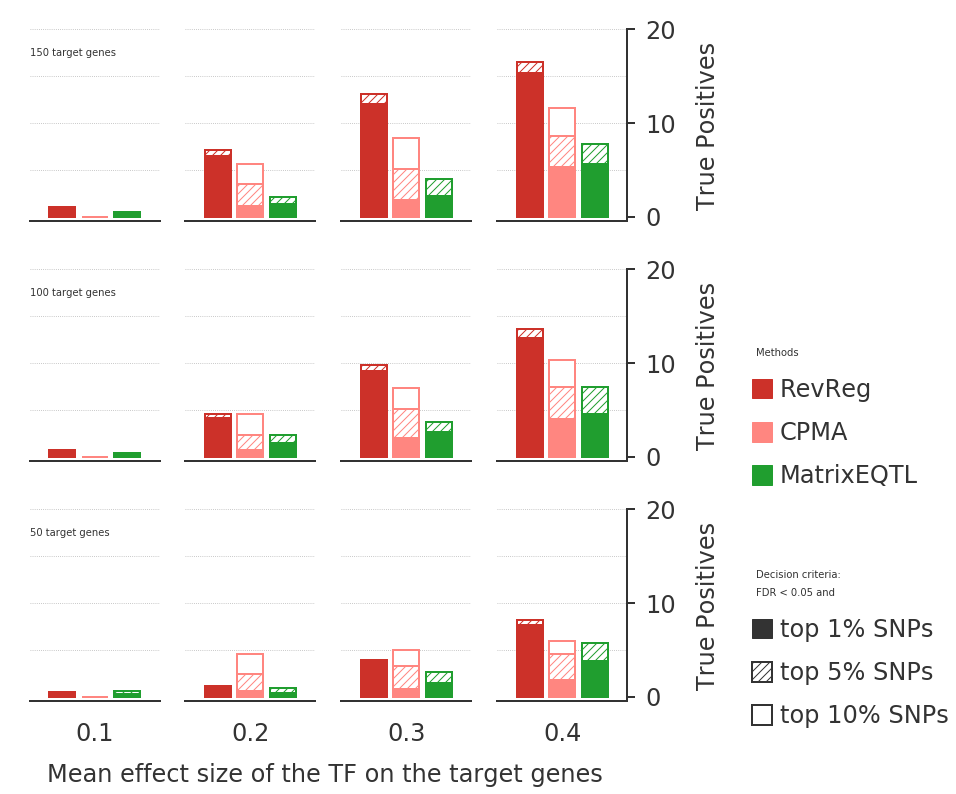

In [8]:
methodcolors = {'tejaas_rr':  '#cc3129ff',
                'tejaas_jpa': '#ff8680ff',
                #'tejaas_jpa': '#cc3129ff',
                'matrixeqtl': '#209E2FFF',
                'matrixeqtl_fdr': '#1fcc80ff'}

methodlabels = {'tejaas_rr': 'RevReg',
                'tejaas_jpa': 'CPMA',
                'matrixeqtl': 'MatrixEQTL'}

yvals_ntop10pc, rownames, colnames = method_to_yvals(methods, data_ntop10pc)
yvals_ntop05pc, _, _               = method_to_yvals(methods, data_ntop05pc)
yvals_ntop01pc, _, _               = method_to_yvals(methods, data_ntop01pc)
nrow = len(rownames)
ncol = len(colnames)

            
fig = plt.figure(figsize = (10, 10))
bgcolor = 'white'
#bgcolor = 'cornsilk'
ymax = 20
ymajorticks = [0, 10, 20]
yminorticks = [5, 10, 15, 20]
ylabel = 'True Positives'
mcolors = [methodcolors[x] for x in methods]

gs = [None for x in range(nrow)]
ax = [None for x in range(nrow * ncol)]

hspacefrac = 0.05
bottompos = [i * (1 / nrow) for i in range(nrow)]
toppos = [bottompos[i] + ( (1 - hspacefrac) / nrow) for i in range(nrow)]

for irow in range(nrow):
    rowtext =  '{:d} target genes'.format(rownames[irow])
    bg_gs = gridspec.GridSpec(1, 1, figure = fig, left = 0, right = 1,
                              bottom = bottompos[irow], top = toppos[irow],
                              hspace = 0, wspace = 0)
    bg_ax = fig.add_subplot(bg_gs[0])
    bg_ax.set_facecolor(bgcolor)
    for side, border in bg_ax.spines.items():
        border.set_visible(False)
    bg_ax.tick_params(bottom = False, top = False, left = False, right = False, 
                   labelleft = False, labelbottom = False)
    bg_ax.text(0.02, 0.82, rowtext)
    if irow == 0:
        bg_ax.set_xlabel('Mean effect size of the TF on the target genes', labelpad = 40, x = 0.43)
    
    gs[irow] = gridspec.GridSpec(1, ncol, figure = fig, 
                                 left = 0.02, right = 0.85, 
                                 bottom = bottompos[irow] + 0.03, top = toppos[irow] - 0.02, 
                                 wspace = 0.2)
    showxlabel = False
    if irow == 0: showxlabel = True

    for icol in range(ncol):
        xlabel = '{:g}'.format(colnames[icol])
        showyaxis = False
        if icol == ncol - 1: showyaxis = True
        idx = irow * ncol + icol
        ax[idx] = fig.add_subplot(gs[irow][icol])
        
        tp10 = [val[0] for key, val in yvals_ntop10pc[idx].items()]
        tp05 = [val[0] for key, val in yvals_ntop05pc[idx].items()]
        tp01 = [val[0] for key, val in yvals_ntop01pc[idx].items()]
        fp10 = [val[1] for key, val in yvals_ntop10pc[idx].items()]
        fp05 = [val[1] for key, val in yvals_ntop05pc[idx].items()]
        fp01 = [val[1] for key, val in yvals_ntop01pc[idx].items()]
        
        single_barplot(ax[idx], tp10, tp05, tp01, fp10, fp05, fp01, 
                       ymax, mcolors,
                       ymajorticks, yminorticks,
                       xlabel, ylabel, showyaxis, showxlabel)

legendtitle = 'Methods'
mhandles = [mpatches.Rectangle((0,0), 20, 20, **{'color': methodcolors[x]}) for x in methods]
mlabels = [methodlabels[x] for x in methods]
mhandler_map = dict()
for x in mhandles:
    mhandler_map[x] = HandlerSquare()
legend = ax[7].legend(handles = mhandles, labels = mlabels, handler_map = mhandler_map,
                      loc = 'lower left', bbox_to_anchor = (1.9, -0.2), frameon = True, title = legendtitle)
legend._legend_box.align = "left"
lframe = legend.get_frame()
#lframe.set_facecolor(bgcolor)
lframe.set_linewidth(0)

legendtitle = "Decision criteria:\nFDR < {:g} and".format(fdr)
basecolor = "#333333"
mhandles = [None for x in range(3)]
mlabels = [None for x in range(3)]
mhandles[0] = mpatches.Rectangle((0,0), 20, 20, **{'color': basecolor})
mhandles[1] = mpatches.Rectangle((0,0), 20, 20, **{'facecolor': 'w', 'edgecolor': basecolor, 
                                                   'linewidth': 2, 'hatch': '///'})
mhandles[2] = mpatches.Rectangle((0,0), 20, 20, **{'facecolor': 'w', 'edgecolor': basecolor,
                                                   'linewidth': 2})
# mlabels[0] = "Best 1% SNPs and FDR < {:g}".format(fdr)
# mlabels[1] = "Best 5% SNPs and FDR < {:g}".format(fdr)
# mlabels[2] = "Best 10% SNPs and FDR < {:g}".format(fdr)
mlabels[0] = "top 1% SNPs"
mlabels[1] = "top 5% SNPs"
mlabels[2] = "top 10% SNPs"
mhandler_map = dict()
for x in mhandles:
    mhandler_map[x] = HandlerSquare()
legend = ax[3].legend(handles = mhandles, labels = mlabels, handler_map = mhandler_map,
                      loc = 'lower left', bbox_to_anchor = (1.9, -0.2), frameon = True, title = legendtitle)
lframe = legend.get_frame()
legend._legend_box.align = "left"
ltitle = legend.get_title()
ltitle.set_linespacing(2)
#lframe.set_facecolor(bgcolor)
lframe.set_linewidth(0)

plt.savefig('../plots/truepos_comparison_tfmag_gtex_ms_correlation.png', bbox_inches='tight')
plt.show()